Семинар 2. Определение языка (language detection)
--------------------

<img src="./img.jpg">

In [2]:
import wikipedia
import numpy as np
import os
import json
import requests

In [3]:
# посмотрим какие языки есть в википедии и какие коды им соответствуют
code2lang = wikipedia.languages()

In [4]:
code2lang

{'aa': 'Qafár af',
 'ab': 'Аҧсшәа',
 'ace': 'Acèh',
 'ady': 'адыгабзэ',
 'ady-cyrl': 'адыгабзэ',
 'aeb': 'تونسي/Tûnsî',
 'aeb-arab': 'تونسي',
 'aeb-latn': 'Tûnsî',
 'af': 'Afrikaans',
 'ak': 'Akan',
 'aln': 'Gegë',
 'als': 'Alemannisch',
 'am': 'አማርኛ',
 'an': 'aragonés',
 'ang': 'Ænglisc',
 'anp': 'अङ्गिका',
 'ar': 'العربية',
 'arc': 'ܐܪܡܝܐ',
 'arn': 'mapudungun',
 'arq': 'جازايرية',
 'ary': 'Maġribi',
 'arz': 'مصرى',
 'as': 'অসমীয়া',
 'ase': 'American sign language',
 'ast': 'asturianu',
 'atj': 'Atikamekw',
 'av': 'авар',
 'avk': 'Kotava',
 'awa': 'अवधी',
 'ay': 'Aymar aru',
 'az': 'azərbaycanca',
 'azb': 'تۆرکجه',
 'ba': 'башҡортса',
 'ban': 'Basa Bali',
 'bar': 'Boarisch',
 'bat-smg': 'žemaitėška',
 'bbc': 'Batak Toba',
 'bbc-latn': 'Batak Toba',
 'bcc': 'جهلسری بلوچی',
 'bcl': 'Bikol Central',
 'be': 'беларуская',
 'be-tarask': 'беларуская (тарашкевіца)\u200e',
 'be-x-old': 'беларуская (тарашкевіца)\u200e',
 'bg': 'български',
 'bgn': 'روچ کپتین بلوچی',
 'bh': 'भोजपुरी',
 'bho': 

In [5]:
# выберем несколько языков с кириллическим алфавитом (судя по названию языка)
langs = ['be', 'bg', 'ky', 'lez' , 'mhr', 'mn', 'mk', 'mo', 'ru', 'sty', 'uk', 'en']

In [6]:
# расшифровка 
[code2lang[lang] for lang  in langs]

['беларуская',
 'български',
 'Кыргызча',
 'лезги',
 'олык марий',
 'монгол',
 'македонски',
 'молдовеняскэ',
 'русский',
 'cебертатар',
 'українська',
 'English']

Выбрать какие-то случайные статьи можно с помощью функции wikipedia.random(n) (n - число статей)

Скачивание занимает некоторое время и может выдавать всякие непредсказуемые ошибки, поэтому не забывайте про добавлять обработчик исключения в аналогичные функции.

In [ ]:
def get_texts_for_lang(lang, n=100): # функция для скачивания статей из википедии
    wikipedia.set_lang(lang)
    wiki_content = []
    pages = wikipedia.random(n)
    
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
        
        except Exception as e:
            print('Skipping page {}'.format(page_name), e)
            continue

        wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

    return wiki_content

In [ ]:
# скачиваем по 120 случайных статей для каждого языка
wiki_texts_test = {}
for lang in langs:
    try:
        wiki_texts_test[lang] = get_texts_for_lang(lang, 10)
    except Exception as e:
        print('ERROR ON - ', lang, e)
        continue
    print(lang, len(wiki_texts_test[lang]))

Я сделал это заранее, чтобы вам не пришлось мучаться.

In [7]:
wiki_texts = json.loads(open('wiki_texts.json', 'r', encoding='utf8').read())

## Как можно определить язык?

### 1 По набору букв

У каждого языка есть какой-то определенный набор символов, которые в нем используются. Даже между двумя очень близкими языками есть различия на уровне символовов. Попробуем определять язык по множеству символов.

In [8]:
from collections import defaultdict
from string import punctuation, digits
punctuation = set(punctuation + '«»—…“”\n\t' + digits)

Создадим множества символов, представляющих язык, по скачанным текстам.

Нужно создать словарь, в котром каждому ключу соотвествует множество. Удобно это сделать с помощью defaultdict. Он устроен примерно как обычный питоновский словарь, но ему можно задать значение нового ключа по умолчанию. 
Синтаксис такой:

***d = defaultdict(callable)***


callable - это такой питоновский объект, который можно вызвать (добавив скобки) и он что-то вернет. Соответственно, для каждого нового элемента будет вызываться этот callable и присваивать элементу значение, которое он вернет. 
Например, **set** - это callable, который при вызове ***set()*** вернет пустое множество. То есть, каждому новому элементу будет соответствовать пустое множество. Аналогично будет с int, dict, tuple, str, float.

Если нужно сделать какой-то особое значение по умолчанию, можно написать отдельную функцию или сделать это через lambda. Например, lamda: {'хороших':0, 'плохих':0} сделает так, чтобы каждому элементу по умолчанию ставился словарь с двумя ключами (хороших, плохих) и нулевыми значениями.

Когда используете defaultdict, помните, d['random_stuff'] не выдаст никакой ошибки и у вас в словаре появится этот объект.


In [9]:
lang2chars = defaultdict(set)

# операция "-" для множества означает разность, т.е. "все елементы x, которых нет в y"
# удобно таким образом отфильтровать все знаки пунктуации
for lang in wiki_texts:
    for text in wiki_texts[lang]:
        text_set = set(text.lower()) - punctuation
        lang2chars[lang].update(text_set)

In [10]:
lang2chars.keys()

dict_keys(['uk', 'mn', 'mhr', 'bg', 'be', 'ky', 'lez', 'en', 'mk', 'ru'])

In [11]:
# посмотрим на какой-нибудь язык
len(lang2chars['ru'])

166

In [12]:
lang2chars['ru']

{' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '°',
 '²',
 '³',
 '¹',
 '×',
 'ß',
 'à',
 'â',
 'ã',
 'ä',
 'ç',
 'è',
 'é',
 'ë',
 'ó',
 'õ',
 'ö',
 'û',
 'ü',
 'ā',
 'ą',
 'č',
 'ė',
 'ī',
 'ı',
 'ś',
 'ş',
 'š',
 'ž',
 'ɐ',
 'ɔ',
 'ɛ',
 'ɫ',
 'ɾ',
 'ʃ',
 'ˈ',
 'ː',
 '́',
 'ά',
 'α',
 'ε',
 'κ',
 'λ',
 'μ',
 'ν',
 'ξ',
 'ο',
 'π',
 'ρ',
 'ς',
 'σ',
 'τ',
 'υ',
 'χ',
 'ω',
 'ό',
 'ώ',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 'ѕ',
 'і',
 'ї',
 'ѣ',
 'ѧ',
 'ѹ',
 '҂',
 '҃',
 'ҡ',
 'ү',
 'ә',
 'ر',
 'م',
 'ه',
 'ṃ',
 'ṇ',
 'ả',
 'ế',
 'ị',
 'ủ',
 'ử',
 'ἄ',
 'ὀ',
 'ὄ',
 'ᾰ',
 'ῑ',
 'ῶ',
 '\u200e',
 '–',
 '’',
 '„',
 '№',
 '→',
 '−',
 '≤',
 '⋅',
 '⩾',
 '井',
 '圭',
 '奈',
 '文',
 '松',
 '梨',
 '武',
 '田',
 '章',
 '규',
 '문',
 '장'}

Теперь сделаем функцию, которая предсказывает язык на основе пересечения множеств символов.

In [13]:
# оператор & означает пересечение

def predict_language(text, lang2char):
    text_chars = set(text.lower())
    lang2sim = {}
    for lang in lang2char:
        intersect = len((text_chars - punctuation) & lang2char[lang])
        lang2sim[lang] = intersect
    
    return max(lang2sim.items(), key=lambda x: x[1])[0]

In [14]:
predict_language('что это за язык такой?', lang2chars)

'lez'

In [15]:
# отклассифицурем все тексты, которые у нас есть
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
true_labels = []
predicted_labels = []

for lang in wiki_texts:
    for text in wiki_texts[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2chars))

In [17]:
print(classification_report(true_labels, predicted_labels))

             precision    recall  f1-score   support

         be       0.95      0.99      0.97        97
         bg       0.97      0.61      0.75        98
         en       1.00      0.21      0.35        94
         ky       1.00      0.49      0.66       100
        lez       0.34      1.00      0.51       100
        mhr       0.93      0.94      0.93        97
         mk       1.00      0.82      0.90       100
         mn       0.62      1.00      0.77        98
         ru       1.00      0.24      0.39        91
         uk       0.95      0.84      0.89        93

avg / total       0.87      0.72      0.71       968



In [18]:
labels = list(set(true_labels))

In [19]:
print(confusion_matrix(true_labels, predicted_labels, labels = labels))

[[ 60   0  31   7   0   0   0   0   0   0]
 [  1  20  54  12   1   1   0   5   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0  98   0   0   0   0   0   0]
 [  0   0  10   1  78   4   0   0   0   0]
 [  0   0   5   1   0  91   0   0   0   0]
 [  0   0  17  33   0   1  49   0   0   0]
 [  0   0   1   0   0   0   0  96   0   0]
 [  1   0  59   5   3   1   0   0  22   0]
 [  0   0  18   0   0   0   0   0   0  82]]


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

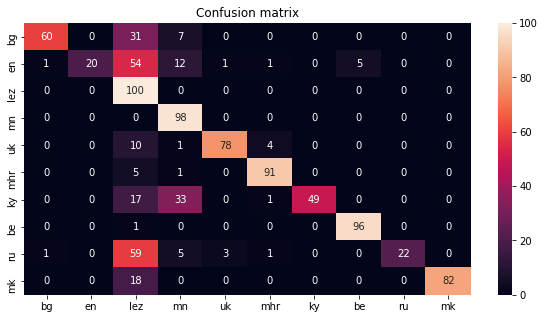

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

### 2 По набору буквенных нграм

Буквенных нграм слишком много для одного множества, поэтому нужно как-то выделить топ-N.

Для частотностей есть Counter. По сути это ***defaultdict(int)*** только немного удобнее.
Можно создавать Counter из любого itarable объекта, складывать два каунтера (одинаковые знаения сложатся, а новые просто добавятся, удобно сортировать элементы по частотности методов Counter.most_common(topn)

In [ ]:
Byte pair encoding 

In [22]:
from collections import Counter

In [62]:
# функция для создания нграммов из строки
def n_grams(a, n):
    ngrams = [a[i:i+n].translate(table).strip(' ') for i in range(0, len(a)+1-n)]
    return set(ngrams)

In [29]:
n_grams('12345', 2)

{'12', '23', '34', '45'}

In [50]:
langs = list(lang2char_ngrams)
stops = set(lang2char_ngrams[langs[0]])

for lang in langs[1:]:
    stops &= lang2char_ngrams[lang]

In [53]:
lang2char_ngrams['ru']

{'  л',
 'лав',
 'лос',
 ' со',
 'рез',
 'бря',
 'ото',
 '  д',
 'нас',
 'ичн',
 'одс',
 'т д',
 'ког',
 'ря ',
 'дер',
 'у с',
 'его',
 'кот',
 'х н',
 ' им',
 'еда',
 'вых',
 ' яв',
 'лем',
 'ся ',
 ' бы',
 '  к',
 'дру',
 'дар',
 'те ',
 'ача',
 'уча',
 'мал',
 'оги',
 'оне',
 'е п',
 'чит',
 'был',
 'ь м',
 'й с',
 'в г',
 'кая',
 'ежд',
 'обо',
 'ить',
 'м о',
 'оде',
 'ску',
 'кий',
 'се ',
 'в м',
 'анг',
 'кал',
 'мел',
 'й н',
 'дни',
 ' вс',
 'с п',
 'ачи',
 'вре',
 'у о',
 'гор',
 'й к',
 'еду',
 'вес',
 'е з',
 'уда',
 'ани',
 'вол',
 'ран',
 'ок ',
 'лож',
 'нес',
 'ыва',
 'еча',
 'ерв',
 'рии',
 'офи',
 'ер ',
 'ает',
 'до ',
 'м и',
 'исл',
 'общ',
 'нно',
 'я п',
 'ант',
 'она',
 'ода',
 'н и',
 'стн',
 'зап',
 'сто',
 'ающ',
 'аме',
 'онс',
 'за ',
 'и б',
 'ное',
 'арт',
 'чес',
 'пол',
 'мат',
 'нгл',
 'ада',
 'пор',
 'а у',
 'озд',
 'иде',
 'етр',
 'нии',
 'рос',
 'лей',
 'лин',
 'жде',
 'нск',
 'ные',
 'я и',
 'ь в',
 'едс',
 'в р',
 'ава',
 'ком',
 ' си',
 'имо',


In [88]:
# посчитаем частотность нграммов
lang2char_ngrams_freqs = defaultdict(Counter)
table = str.maketrans({ch: None for ch in punctuation})

for lang in wiki_texts:
    for text in wiki_texts[lang]:
        char_ngrams = n_grams(text.lower().translate(table), 3)
        lang2char_ngrams_freqs[lang].update(char_ngrams)

# сделаем множества с топ 300 нграммамим

lang2char_ngrams = {}
for lang in lang2char_ngrams_freqs:
    topn = [word for word, freq in lang2char_ngrams_freqs[lang].most_common(200)]
    lang2char_ngrams[lang] = set(topn)


In [89]:
# lang2char_ngrams['ru']

In [137]:
def predict_language(text, lang2char):
    text_ngrams = n_grams(text.lower().translate(table), 2)
    
    lang2sim = {}
    
    for lang in lang2char:
        intersect = len((text_ngrams - punctuation) & lang2char[lang])
        lang2sim[lang] = intersect
    
    return max(lang2sim, key=lambda x: lang2sim[x])
#     return lang2sim

In [91]:
predict_language('Что это за язык ещё такой', lang2char_ngrams)

'ru'

In [92]:
true_labels = []
predicted_labels = []

for lang in wiki_texts:
    for text in wiki_texts[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2char_ngrams))

In [93]:
print(classification_report(true_labels, predicted_labels))

             precision    recall  f1-score   support

         be       0.99      0.99      0.99        97
         bg       0.99      0.99      0.99        98
         en       0.92      1.00      0.96        94
         ky       0.99      0.99      0.99       100
        lez       0.99      0.97      0.98       100
        mhr       1.00      0.96      0.98        97
         mk       0.99      1.00      1.00       100
         mn       1.00      0.96      0.98        98
         ru       0.99      1.00      0.99        91
         uk       1.00      1.00      1.00        93

avg / total       0.99      0.99      0.99       968



In [94]:
# Лучше тут уже некуда

## Задание

Напишите функцию, которая будет принимать текст производной длинны и языка (из тех, что у нас уже есть) и выводить основной язык и слова, которые не соответствуют это языку текста.

То есть по запросу "шо это за язык?
должно получится "Основной язык  - ru, не соотвествующее слова: шо"

In [138]:
def predict_foreign_words(text):
    lang = predict_language(text, lang2vec)
    
    words = [word.translate(table) for word in text.lower().split()]
    
    foreign_words = []
    for word in words:
        p = predict_language(word, lang2vec)
        if p != lang:
            foreign_words.append((word, p))
    
    return lang, foreign_words

In [142]:
test_text_1 = 'Младший лейтенант мальчик молодой everybody хотят to dance с тобой'
print(predict_foreign_words(test_text_1))

('bg', [('младший', 'mhr'), ('мальчик', 'lez'), ('молодой', 'ru'), ('everybody', 'en'), ('to', 'en'), ('dance', 'en'), ('с', 'lez'), ('тобой', 'ru')])


In [143]:
test_text_2 = 'Тут хто-нэбудь розмовляйе по-русски?'
print(predict_foreign_words(test_text_2 ))

('ru', [('хтонэбудь', 'mn')])


In [135]:
test_text_3 = 'Як дабрацца российского пасольства??'
print(predict_foreign_words(test_text_3 ))

('mhr', [('як', 'uk'), ('дабрацца', 'be'), ('пасольства', 'be')])


In [136]:
test_text_4 = 'Ончыч Куженер кундемысе «Ӱжара» газета редакторлан тыршен,\
вара райсовет исполкомын вуйлатышыжлан,\
КПСС райкомын икымше секретарьжылан ыштен.'
print(predict_foreign_words(test_text_4))

('mhr', [('ӱжара', 'ky'), ('газета', 'be'), ('редакторлан', 'ky'), ('райсовет', 'bg'), ('секретарьжылан', 'ky')])


### Дополнительное задание

До этого мы учитывали только само наличие нграмм или символов, но очевидно, что важно ещё и распределние частот по этим нграммам. В родственных языках символы могут быть почти одинаковые, но вот частота употребления точно будет отличаться.

Попробуем представить каждый язык как распределение на символьных нграммах.

In [ ]:
import numpy as np

In [97]:
table

{9: None,
 10: None,
 33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 48: None,
 49: None,
 50: None,
 51: None,
 52: None,
 53: None,
 54: None,
 55: None,
 56: None,
 57: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None,
 171: None,
 187: None,
 8212: None,
 8220: None,
 8221: None,
 8230: None}

In [127]:
# cоздадим общий словарь нграммов с частотностью
vocab = Counter()

for lang in wiki_texts:
    for text in wiki_texts[lang]:
        vocab.update(n_grams(text, 2))

# выберем топ-300 нграммов и сохраним их в список
vocab = [word for word,_ in vocab.most_common(5000)]
#сделаем словарь нграм-индекс, индекс слова для удобства
id2ngram = {i:ngram for i, ngram in enumerate(vocab)}
ngram2id = {ngram:i for i, ngram in enumerate(vocab)}

Теперь нужно представить каждый язык, как вектор размером словаря.

In [100]:
# воспользуемся defauldict
# по умолчанию каждому элементу поставим в соотвествие np.zeros((len(vocab)))

In [128]:
lang2vec = defaultdict(lambda: np.zeros((len(vocab))))

Теперь попробуйте написать код, который заполнит вектора языков числами.

In [129]:
for lang in wiki_texts:
    for text in wiki_texts[lang]:
        ngrams = n_grams(text.lower().translate(table), 2)
        for ngram in ngrams:
            if ngram in ngram2id:
                lang2vec[lang][ngram2id[ngram]] += 1
            
            

In [130]:
# lang2vec

Перепишите функцию определения языка, чтобы она считала не пересечение с множеством, а косинусную близость.

In [140]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_language(text, lang2vec):
    text_ngrams = n_grams(text, 2)
    vec = np.zeros(len(vocab))
    
    for ngram in text_ngrams:
        if ngram in ngram2id:
            vec[ngram2id[ngram]] += 1
    
    # ваш код здесь
    # ...
    
    lang2sim = {}
    
    for lang in lang2vec:
        # ваш код здесь
        #...
        
        similarity = cosine_similarity(vec.reshape(1, -1), lang2vec[lang].reshape(1, -1)) # добавьте нужные аргументы
        
        lang2sim[lang] = similarity[0]
    
    return max(lang2sim, key=lambda x: lang2sim[x])


Проверьте качество на небольшой тестовой выборке.

In [107]:
wiki_texts_test = json.loads(open('wiki_texts_test.json', encoding='utf8').read())

In [110]:
true_labels = []
predicted_labels = []

for lang in wiki_texts_test:
    for text in wiki_texts_test[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2vec))

In [111]:
print(classification_report(true_labels, predicted_labels))

             precision    recall  f1-score   support

         be       1.00      1.00      1.00        10
         bg       1.00      0.67      0.80         9
         en       1.00      1.00      1.00        10
         ky       1.00      1.00      1.00        10
        lez       1.00      1.00      1.00        10
        mhr       1.00      1.00      1.00        10
         mk       1.00      1.00      1.00        10
         mn       1.00      1.00      1.00        10
         ru       0.75      1.00      0.86         9
         uk       1.00      1.00      1.00        10

avg / total       0.98      0.97      0.97        98

